In [1]:
cd /orange/adamginsburg/w51/gtc/GTC2-20AFLO/OB0001/object

/orange/adamginsburg/w51/gtc/GTC2-20AFLO/OB0001/object


In [2]:
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
import pylab as pl
from astropy import visualization, coordinates, units as u
from astroquery.vizier import Vizier
from photutils import DAOStarFinder
from astropy.wcs.utils import fit_wcs_from_points

In [3]:
files = !ls *fits
filehandle = fits.open(files[1])

In [18]:
def findwcs(filehandle):
    
    ww = WCS(filehandle[0].header)
    
    # cx, cy are 1024
    cy, cx = (x/2 for x in filehandle[0].data.shape)
    
    ra, dec = ww.wcs_pix2world(cx, cy, 0)*u.deg
    
    center = coordinates.SkyCoord(ra, dec, frame='fk5')
    
    tables = Vizier(row_limit=10000).query_region(center, radius=5*u.arcmin, catalog='2MASS')
    table = tables[0]
    table_coordinates = coordinates.SkyCoord(table['RAJ2000'], table['DEJ2000'], frame='fk5')
    brightstars = table['Jmag'] < 12
    
    # because the offset was so bad, I decided to try to fix the WCS a little before doing cross-matching
    # the code below re-loads the WCS, then shifts it up by 4" and left by 1.8"
    ww = WCS(filehandle[0].header)
    ww.wcs.crval[1] += 4/3600
    ww.wcs.crval[0] -= 1.8/3600
    
    std = filehandle[0].data.std() # crummy guess!!
    daofind = DAOStarFinder(fwhm=3.0, threshold=4.*std)
    starcat = daofind(filehandle[0].data - np.median(filehandle[0].data)) 
    
    xc, yc = ww.all_world2pix(table_coordinates.ra, table_coordinates.dec, 0)
    ra, dec = ww.all_pix2world(starcat['xcentroid'], starcat['ycentroid'], 0)*u.deg
    starfind_coords = coordinates.SkyCoord(ra, dec, frame='fk5')
    match_index, match_distance, _ = coordinates.match_coordinates_sky(starfind_coords, table_coordinates)
    
    new_sky_coordinates = table_coordinates[match_index]
    new_sky_coordinates_xy = ww.all_world2pix(new_sky_coordinates.ra, new_sky_coordinates.dec, 0)
    
    xy_starfind = np.array([starcat['xcentroid'], starcat['ycentroid']])
    new_wcs = fit_wcs_from_points(xy_starfind, new_sky_coordinates, sip_degree=2)
    new_ra, new_dec = new_wcs.wcs_pix2world(starcat['xcentroid'], starcat['ycentroid'], 0)*u.deg
    
    ra_residual = (new_ra-new_sky_coordinates.ra).to(u.arcsec)
    dec_residual = (new_dec-new_sky_coordinates.dec).to(u.arcsec)
    
    bad_matches = (ra_residual < -2*u.arcsec) | (ra_residual > 2*u.arcsec) | (dec_residual > 2*u.arcsec) | (dec_residual < -2*u.arcsec)
    
    xy_starfind2 = xy_starfind.T[~bad_matches].T
    new_sky_coordinates2 = new_sky_coordinates.T[~bad_matches].T
    new_wcs2 = fit_wcs_from_points(xy_starfind2, new_sky_coordinates2, sip_degree=3)
    new_ra2, new_dec2 = new_wcs2.wcs_pix2world(starcat['xcentroid'], starcat['ycentroid'], 0)*u.deg
    
    ra_residual2 = (new_ra2-new_sky_coordinates.ra).to(u.arcsec)
    dec_residual2 = (new_dec2-new_sky_coordinates.dec).to(u.arcsec)
    
    return new_wcs2, starcat, table_coordinates


In [19]:
file2 = fits.open(files[2])

new_wcs, starcat, table_coordinates = findwcs(file2)

(-0.5, 2047.5, -0.5, 2047.5)

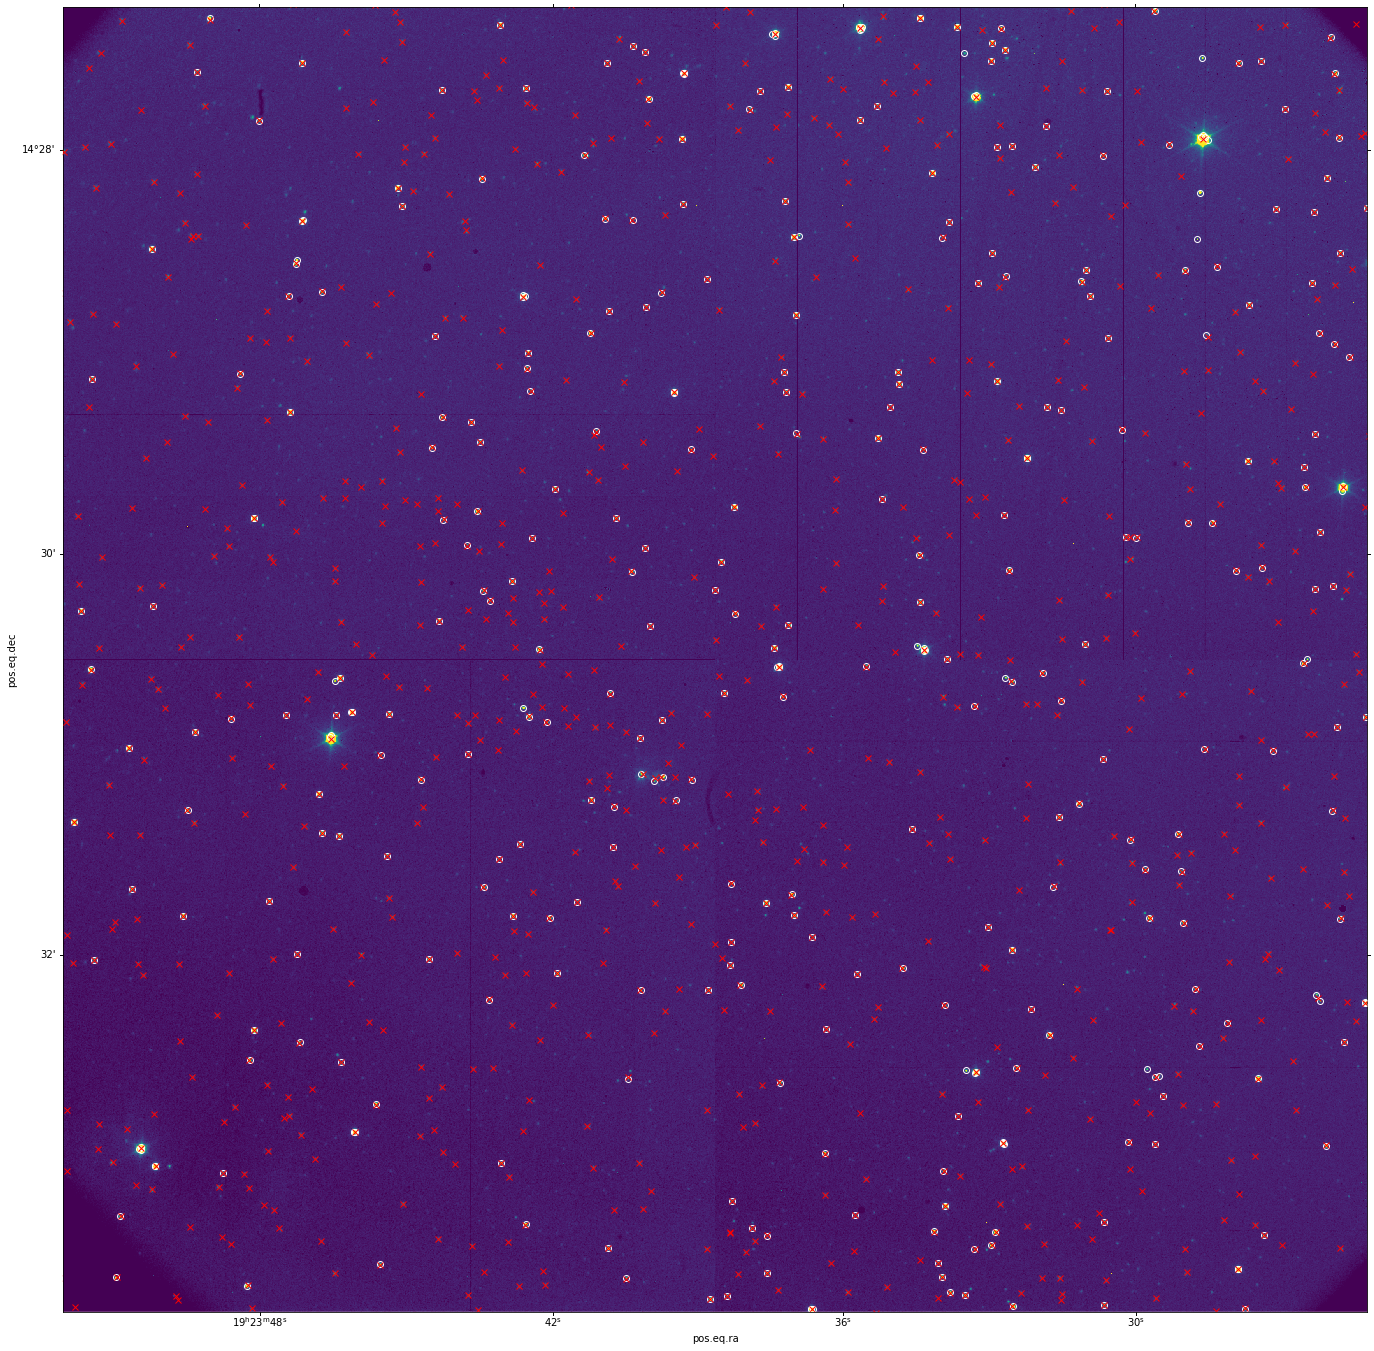

In [21]:
pl.figure(figsize=(24,24))
ax = pl.subplot(projection=new_wcs)
pl.imshow(file2[0].data, norm=visualization.simple_norm(file2[0].data, min_percent=1, max_percent=99.9))
axlims = ax.axis()
pl.plot(starcat['xcentroid'], starcat['ycentroid'], 'wo', markeredgecolor='w', markerfacecolor='none')
pl.plot(table_coordinates.ra,
        table_coordinates.dec,
        transform=ax.get_transform('world'), marker='x', color='r', linestyle='none')
ax.axis(axlims)